In [19]:
import pandas as pd
import numpy as np
import re #regular expression 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [20]:
def create_data_frame(data): 

    # split the text block into lines and then into individual values
    lines = data.strip().split('\n')
    data = [re.split(r'\s+', line.strip()) for line in lines]

    df = pd.DataFrame(data[1:], columns=data[0]).apply(pd.to_numeric)
    df.set_index('N', inplace=True)

    # Show the prepared DataFrame
    df.head()
    
    return df

In [21]:
colors = ['blue','green', 'red']
def plot_data_frame(df): 
    
    plt.figure(figsize=(10, 6))

    for i, column in enumerate(df.columns):
        plt.plot(df.index, df[column], label=column, marker='o', color=colors[i])

    plt.title('error rate vs N')
    plt.xlabel('plaquette repetition (N)')
    plt.ylabel('P(1)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
def poly2(x, a, b, c):
        return a * x**2 + b * x + c

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


def find_coeff(df, poly2, poly3): 

    # fit a polynomial of degree 2 and degree 3 to the data for each device and store the coefficients
    coefficients = {}
    for column in df.columns:
        popt_2, _ = curve_fit(poly2, df.index, df[column])
        #popt_3, _ = curve_fit(poly3, df.index, df[column])

        # Store the coefficients
        coefficients[column] = {
            'degree_2': popt_2,
            #'degree_3': popt_3
        }

    return coefficients


In [23]:
def plot_fitted_curves(df, coefficients, poly2, poly3):
    # Plot the data and the fitted curves
    plt.figure(figsize=(10, 6))

    # Plot each device's data and fitted polynomial
    for i, column in enumerate(df.columns):
        # Scatter plot for actual data points
        plt.scatter(df.index, df[column], label=f'{column} Data', marker='o', color=colors[i])

        # Plot polynomial degree 2
        plt.plot(df.index, poly2(df.index, *coefficients[column]['degree_2']), label=f'{column} Degree 2 Fit', linestyle='--', color=colors[i])

        # Plot polynomial degree 3
        #plt.plot(df.index, poly3(df.index, *coefficients[column]['degree_3']), label=f'{column} Degree 3 Fit', linestyle='-.')

    plt.title('Error Rates vs. N with Polynomial Fits')
    plt.xlabel('N')
    plt.ylabel('P(ancilla)=1')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
# plaquette 3 1000shots
data1 = """
N 	Harmony-11-Sim	Aria1-25-Sim	Aria1-25-QPU
1	0.090	0.025	0.035
2	0.145	0.050	0.050
3	0.200	0.075	0.085
4	0.185	0.070	0.080
5	0.290	0.105	0.090
6	0.365	0.070	0.115
7	0.325	0.110	0.125
8	0.410	0.125	0.150
9	0.455	0.155	0.145
10	0.435	0.160	0.155
11	0.505	0.180	0.185
12	0.430	0.150	0.170
13	0.475	0.135	0.225
14	0.490	0.235	0.235
15	0.450	0.220	0.245
16	0.565	0.235	0.210
17	0.545	0.250	0.325
18	0.550	0.195	0.385
19	0.545	0.190	0.310
20	0.500	0.240	0.310
"""

df1 = create_data_frame(data1)
#plot_data_frame(df1)

In [25]:
coefficients = find_coeff(df1, poly2, poly3)
print(coefficients) 

{'Harmony-11-Sim': {'degree_2': array([-0.00160999,  0.05620455,  0.03863596])}, 'Aria1-25-Sim': {'degree_2': array([-0.00035173,  0.01814952,  0.00865351])}, 'Aria1-25-QPU': {'degree_2': array([0.00022272, 0.01116507, 0.03230702])}}


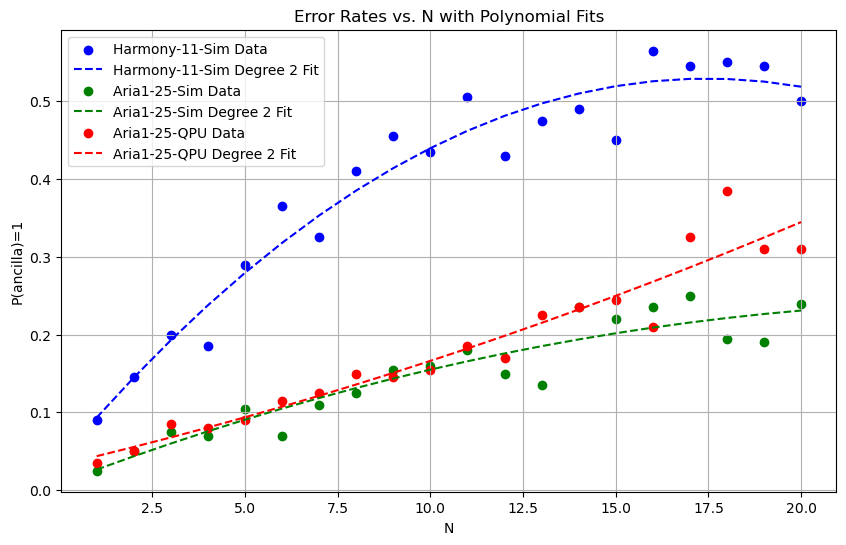

In [26]:
plot_fitted_curves(df1, coefficients, poly2, poly3)

In [27]:
def calculate_data(trial_coeffs): 
    
    # calculate the mean and standard deviation for the coefficients across trials
    coefficients_mean = np.mean(trial_coeffs, axis=0)
    coefficients_std = np.std(trial_coeffs, axis=0)

    upper = coefficients_mean + coefficients_std
    lower = coefficients_mean - coefficients_std

    x = np.linspace(1, 10, 100)
    y = poly2(x, coefficients_mean[0], coefficients_mean[1], coefficients_mean[2])

    # calculate the upper and lower bounds using the standard deviation
    y_upper = poly2(x, upper[0], upper[1], upper[2])
    y_lower = poly2(x, lower[0], lower[1], lower[2])

    return x, y, y_upper, y_lower


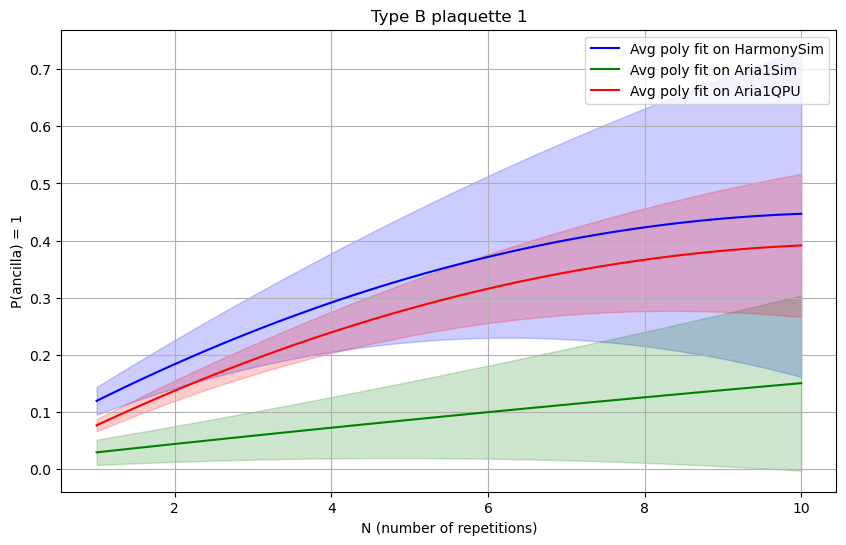

In [28]:
#circuit 1

harmony_coeffs = np.array([
    [-0.00160999,  0.05620455,  0.03863596],  # trial 1
    [-0.00488258,  0.08904773,  0.04511667],
    [-0.00401515,  0.0795    ,  0.06033333]# trial 2
    #0.11, -0.019, 0.0045] # trial 3
])

aria1_coeffs = np.array([
    [0.00079545, 0.00514697, 0.03396667],  # trial 1
    [-7.08333336e-04,  2.14159091e-02,  8.33333312e-05],
    [-0.00054924,  0.01889015,  0.00905   ]# trial 2
    #0.11, -0.019, 0.0045] # trial 3
])

qpu_coeffs = np.array([
    [-0.0025    ,  0.06537879,  0.01486667],  # trial 1
    [-0.00392045,  0.07520379,  0.00441667] # trial 2
    #0.11, -0.019, 0.0045] # trial 3
])


x1, y1, y_upper1, y_lower1 = calculate_data(harmony_coeffs)
x2, y2, y_upper2, y_lower2 = calculate_data(aria1_coeffs)
x3, y3, y_upper3, y_lower3 = calculate_data(qpu_coeffs)


plt.figure(figsize=(10, 6))

# Plot the Harmony polynomial
plt.plot(x1, y1, label='Avg poly fit on HarmonySim', color=colors[0])
plt.fill_between(x1, y_lower1, y_upper1, color=colors[0], alpha=0.2)

# Plot for Aria1 coefficients
plt.plot(x2, y2, label='Avg poly fit on Aria1Sim', color=colors[1])
plt.fill_between(x2, y_lower2, y_upper2, color=colors[1], alpha=0.2)

# Plot for QPU coefficients
plt.plot(x3, y3, label='Avg poly fit on Aria1QPU', color=colors[2])
plt.fill_between(x3, y_lower3, y_upper3, color=colors[2], alpha=0.2)


plt.title(f'Type B plaquette 1')
plt.xlabel('N (number of repetitions)')
plt.ylabel('P(ancilla) = 1')
plt.legend()
plt.grid(True)
plt.savefig('b1')
plt.show()

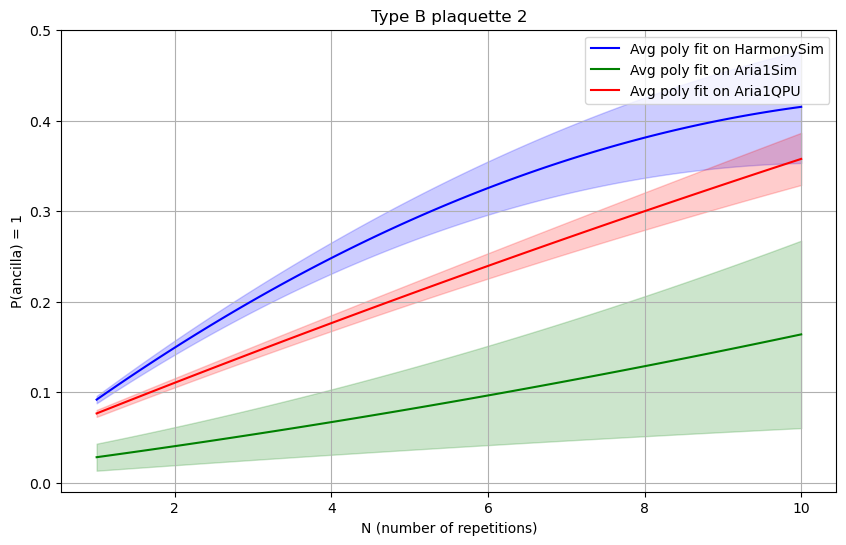

In [29]:
#circuit 2

harmony_coeffs = np.array([
    [-0.00304545,  0.06840303,  0.02773333],  # trial 1
    [-0.00236364,  0.06301818,  0.0298    ] # trial 2
    #0.11, -0.019, 0.0045] # trial 3
])

aria1_coeffs = np.array([
    [0.00082197, 0.00640076, 0.02635   ],  # trial 1
    [-0.00010606,  0.01589394,  0.00686667] # trial 2
    #0.11, -0.019, 0.0045] # trial 3
])

qpu_coeffs = np.array([
    [-0.00052652,  0.03570682,  0.03888333],  # trial 1
    [-0.00015152,  0.03427879,  0.0448    ] # trial 2
    #0.11, -0.019, 0.0045] # trial 3
])


x1, y1, y_upper1, y_lower1 = calculate_data(harmony_coeffs)
x2, y2, y_upper2, y_lower2 = calculate_data(aria1_coeffs)
x3, y3, y_upper3, y_lower3 = calculate_data(qpu_coeffs)


plt.figure(figsize=(10, 6))

# Plot the average polynomial
plt.plot(x1, y1, label='Avg poly fit on HarmonySim', color='blue')
plt.fill_between(x1, y_lower1, y_upper1, color='blue', alpha=0.2)

# Plot for Aria1 coefficients
plt.plot(x2, y2, label='Avg poly fit on Aria1Sim', color='green')
plt.fill_between(x2, y_lower2, y_upper2, color='green', alpha=0.2)

# Plot for QPU coefficients
plt.plot(x3, y3, label='Avg poly fit on Aria1QPU', color='red')
plt.fill_between(x3, y_lower3, y_upper3, color='red', alpha=0.2)


plt.title(f'Type B plaquette 2')
plt.xlabel('N (number of repetitions)')
plt.ylabel('P(ancilla) = 1')
plt.legend()
plt.grid(True)
plt.savefig('b2')
plt.show()

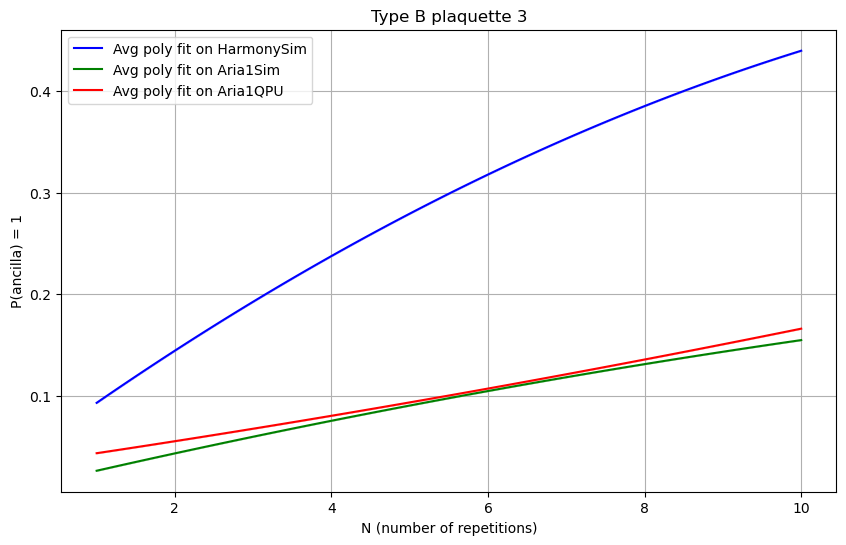

In [30]:
#circuit 3

harmony_coeffs = np.array([
   [-0.00160999,  0.05620455,  0.03863596],
   #[-0.00165909,  0.05716515,  0.04796667],
   #[-0.00317045,  0.06858409,  0.02785   ]
])

aria1_coeffs = np.array([
   [-0.00035173,  0.01814952,  0.00865351],  # trial 1
    #[0.00011742, 0.01299318, 0.01011667], # trial 2
    #[-0.00066667,  0.02019394,  0.0072    ] # trial 3
])

qpu_coeffs = np.array([
   [0.00022272, 0.01116507, 0.03230702],  # trial 1
 #[0.00022272, 0.01116507, 0.03230702] # trial 2
#0.11, -0.019, 0.0045] # trial 3
])


x1, y1, y_upper1, y_lower1 = calculate_data(harmony_coeffs)
x2, y2, y_upper2, y_lower2 = calculate_data(aria1_coeffs)
x3, y3, y_upper3, y_lower3 = calculate_data(qpu_coeffs)


plt.figure(figsize=(10, 6))

# Plot the average polynomial
plt.plot(x1, y1, label='Avg poly fit on HarmonySim', color='blue')
plt.fill_between(x1, y_lower1, y_upper1, color='blue', alpha=0.2)

# Plot for Aria1 coefficients
plt.plot(x2, y2, label='Avg poly fit on Aria1Sim', color='green')
plt.fill_between(x2, y_lower2, y_upper2, color='green', alpha=0.2)

# Plot for QPU coefficients
plt.plot(x3, y3, label='Avg poly fit on Aria1QPU', color='red')
plt.fill_between(x3, y_lower3, y_upper3, color='red', alpha=0.2)


plt.title(f'Type B plaquette 3')
plt.xlabel('N (number of repetitions)')
plt.ylabel('P(ancilla) = 1')
plt.legend()
plt.grid(True)
plt.savefig('b3')
plt.show()

In [35]:
array = [
    [0.0825],
    [0.2475, 0.195],
    [0.0525, 0.3975, 0.625],
    [0.3775, 0.2525, 0.6275, 0.3575],
    [0.2875, 0.435, 0.18, 0.2875, 0.5825] 
]

# Formatting and printing the array
formatted_array = "\n".join(" ".join(str(num) for num in row) for row in array)
print(formatted_array)

0.0825
0.2475 0.195
0.0525 0.3975 0.625
0.3775 0.2525 0.6275 0.3575
0.2875 0.435 0.18 0.2875 0.5825
